In [11]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                        roc_curve, auc, roc_auc_score, log_loss)
from sklearn.model_selection import GroupKFold, GroupShuffleSplit
from sklearn.feature_selection import SelectKBest, chi2, f_classif, mutual_info_classif
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, roc_auc_score


In [12]:
data_path = '/home/edumaba/Public/MPhil_Thesis/Code/wear_uropatch/pipeline/modified/data_extracted_features/three_class_pp_3s_no.csv'
features = pd.read_csv(data_path)
features.drop(columns=['center_time', 'start_time', 'end_time'], inplace=True)

label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(features['label'])

features['label'] = labels

X = features.drop(columns=['experiment_id', 'label'])
y = features['label']
groups = features['experiment_id']

In [13]:
def generate_accuracy_and_heatmap(model, X, y):
    y_pred = model.predict(X)
    
    # Define class order with 'void' first (even though it's encoded as 1)
    # classes_ordered = ['void', 'non-void']  # Display order you want
    # labels_ordered = [1, 0]  # Corresponding encoded values
    
    classes_ordered = ['pre-void','void', 'post-void']  # Display order you want
    labels_ordered = [1, 2, 0]  # Corresponding encoded values
    
    ac = accuracy_score(y, y_pred)
    # f_score = f1_score(y, y_pred, average='macro', pos_label=1)  # void as positive
    f_score = f1_score(y, y_pred, average='macro', pos_label=2)  # void as positive
    
    print("Accuracy is: ", ac)
    print("F1 Score is: ", f_score)
    print('\n')
    
    # Crosstab
    print(pd.crosstab(pd.Series(y_pred, name='Predicted'), 
                    pd.Series(y, name='Actual')))
    print('\n')
    
    # Confusion matrix with void on top
    cm = confusion_matrix(y, y_pred, labels=labels_ordered)  # [1, 0] order
    cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, 
                                    display_labels=classes_ordered)  # ['void', 'non-void']
    cm_display.plot()
    plt.show()
    
    # Classification report with void first
    report = classification_report(y, y_pred, 
                                labels=labels_ordered,  # [1, 0]
                                target_names=classes_ordered)  # ['void', 'non-void']
    print("Classification Report:")
    print(report)
    
    return 1

In [14]:
splitter = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, test_idx = next(splitter.split(X, y, groups))

X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

In [15]:
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


Accuracy is:  0.4834123222748815
F1 Score is:  0.47696392443370095


Actual     0  1   2
Predicted          
0          4  4   4
1          4  0  12
2          2  2   5




/home/edumaba/Public/MPhil_Thesis/Code/wear_uropatch/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1784: UserWarning: Note that pos_label (set to 2) is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(


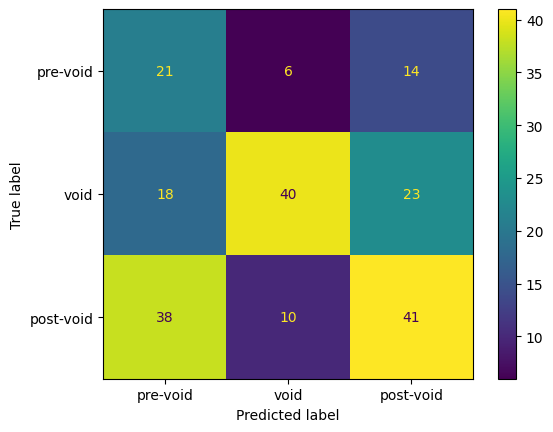

Classification Report:
              precision    recall  f1-score   support

    pre-void       0.27      0.51      0.36        41
        void       0.71      0.49      0.58        81
   post-void       0.53      0.46      0.49        89

    accuracy                           0.48       211
   macro avg       0.50      0.49      0.48       211
weighted avg       0.55      0.48      0.50       211



1

In [16]:
generate_accuracy_and_heatmap(model, X_test, y_test)

In [17]:
select_feature = SelectKBest(f_classif, k=5).fit(X_train, y_train)

In [18]:
# # Ensure full display
# pd.set_option("display.max_rows", None)   # Show all rows
# pd.set_option("display.max_columns", None)  # Show all columns
# pd.set_option("display.width", None)    # No wrapping
# pd.set_option("display.max_colwidth", None)  # Show long column values


selected_features_df = pd.DataFrame({'Feature':list(X_train.columns),
                                    'Scores':select_feature.scores_})
selected_features_df.sort_values(by='Scores', ascending=False)

,Feature,Scores
81,gyr_y_hjorth_frequency,64.308393
95,gyr_z_spectral_spread,60.306818
98,gyr_z_hjorth_frequency,57.987339
68,gyr_y_permutation_entropy,54.421171
78,gyr_y_spectral_spread,52.376316
...,...,...
46,acc_z_peak_frequency_ratio,6.849307
67,gyr_x_snr,5.376369
63,gyr_x_peak_frequency_ratio,5.101088
87,gyr_z_mean,2.637149


In [19]:
X_train_selected = select_feature.transform(X_train)
X_test_selected = select_feature.transform(X_test)

In [20]:
generate_accuracy_and_heatmap(model, X_test_selected, y_test)

/home/edumaba/Public/MPhil_Thesis/Code/wear_uropatch/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


ValueError: X has 5 features, but RandomForestClassifier is expecting 102 features as input.